In [1]:
import csv
import numpy as np
import datetime
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.sparse import csc_matrix
from dateutil import rrule
from collections import OrderedDict
import scipy.sparse.linalg as linalg

DAY = 86400000000000

# Generate ruleset for holiday observances on the NYSE

def NYSE_holidays(a=datetime.date.today(), b=datetime.date.today()+datetime.timedelta(days=365)):
    rs = rrule.rruleset()

    # Include all potential holiday observances
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=31, byweekday=rrule.FR)) # New Years Day  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, bymonthday= 1))                     # New Years Day  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, bymonthday= 2, byweekday=rrule.MO)) # New Years Day    
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 1, byweekday= rrule.MO(3)))            # Martin Luther King Day   
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 2, byweekday= rrule.MO(3)))            # Washington's Birthday
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, byeaster= -2))                                  # Good Friday
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 5, byweekday= rrule.MO(-1)))           # Memorial Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 3, byweekday=rrule.FR)) # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 4))                     # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 7, bymonthday= 5, byweekday=rrule.MO)) # Independence Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth= 9, byweekday= rrule.MO(1)))            # Labor Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=11, byweekday= rrule.TH(4)))            # Thanksgiving Day
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=24, byweekday=rrule.FR)) # Christmas  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=25))                     # Christmas  
    rs.rrule(rrule.rrule(rrule.YEARLY, dtstart=a, until=b, bymonth=12, bymonthday=26, byweekday=rrule.MO)) # Christmas 
    
    # Exclude potential holidays that fall on weekends
    rs.exrule(rrule.rrule(rrule.WEEKLY, dtstart=a, until=b, byweekday=(rrule.SA,rrule.SU)))

    return rs
    
# Generate ruleset for NYSE trading days

def NYSE_tradingdays(a=datetime.date.today(), b=datetime.date.today()+datetime.timedelta(days=365)):
    rs = rrule.rruleset()
    rs.rrule(rrule.rrule(rrule.DAILY, dtstart=a, until=b))
    
    # Exclude weekends and holidays
    rs.exrule(rrule.rrule(rrule.WEEKLY, dtstart=a, byweekday=(rrule.SA,rrule.SU)))
    rs.exrule(NYSE_holidays(a,b))
    
    return rs


# Count NYSE holidays days in next 4 years
hdays =list(NYSE_holidays(datetime.datetime(2011,1,1),datetime.datetime(2014,12,31)))

fields = ['caldt','spindx']
sp500 = pd.read_csv('./Datasets/S&P500.csv', skipinitialspace=True, usecols=fields)
sp500['caldt'] = pd.to_datetime(sp500['caldt'], format='%m/%d/%Y', utc=True)
sp500.rename(index=str, columns={"caldt": "date"}, inplace=True)

date_col = 'date'
sym_col = 'symbol'
exp_date_col = 'exdate'
strike_price_col = 'strike_price'
best_bid_col = 'best_bid'
best_ask_col = 'best_offer'
imp_vol_col = 'impl_volatility'
volumn_col = 'volume'
tenor_col = 'Tenor'
indx_col = 'spindx'

fields = [date_col, sym_col, exp_date_col, strike_price_col, best_bid_col, best_ask_col, imp_vol_col, volumn_col]

#Read options_data
df = pd.read_csv('./Datasets/option_data.csv', skipinitialspace=True, usecols=fields)

#Extract spxw
spxw = df[df[sym_col].str.contains('SPXW')]

#Format Dates
df[date_col] = pd.to_datetime(df[date_col], format='%m/%d/%Y', utc=True)
df[exp_date_col] = pd.to_datetime(df[exp_date_col], format='%m/%d/%Y', utc=True)

#Create Tenor
df[tenor_col]=df[exp_date_col]-df[date_col]
df = pd.merge(df, sp500, on=date_col, how='left')

In [2]:
#Build Moneyness
sLength = len(df[date_col])
abs_diff_col = 'abs_diff'
moneyness_col = 'moneyness'
IVATM_col = 'IVATM'

df[abs_diff_col] = abs(df[strike_price_col] - 1000 * df[indx_col])
#get the IVATM for each option grouped by start date and tenor (expiry date)
IVATM = df.loc[df.groupby([date_col, exp_date_col])[abs_diff_col].idxmin(), [date_col, exp_date_col, imp_vol_col]]
IVATM.rename(index=str, columns={imp_vol_col: IVATM_col}, inplace=True)
df = pd.merge(df, IVATM, on=[date_col, exp_date_col],  how='left')
df[moneyness_col] = np.log(df[strike_price_col] / (1000 * df[indx_col])) / \
    (np.sqrt((df[tenor_col].values / DAY).astype(float) / 365) * df[IVATM_col])

In [3]:
#Delete 0 volume entries
df=df[df[volumn_col]>0]

#Tenor criterion
# at least 10 different strikes across the same tenor
counts = df.groupby([date_col, exp_date_col]).size().reset_index(name='counts')
valid_tenors = counts[counts['counts'] > 9][[date_col, exp_date_col]]

#front maturity contract maturity must be less than 9 days and have moneyness less than -3.5
front_maturities = df.loc[df.groupby([date_col])[tenor_col].idxmin(), [date_col, tenor_col]]
front_maturities = front_maturities[(front_maturities[tenor_col].values / DAY).astype(int) < 9]
front_contracts = pd.merge(df, front_maturities, on=[date_col, tenor_col], how="inner")
front_moneyness = front_contracts[[date_col, tenor_col, moneyness_col]] \
    .groupby([date_col, tenor_col]).agg(np.min).reset_index()
valid_dates = front_moneyness[front_moneyness[moneyness_col] < -3.5][[date_col]]

df = pd.merge(df, valid_tenors, on=[date_col, exp_date_col], how="inner")
df = pd.merge(df, valid_dates, on=[date_col], how="inner")

#Maturity criterion
df=df[(df[tenor_col].values / DAY).astype(int) < 365]

#Moneyness criterion
df=df[df[moneyness_col]>-15]
df=df[df[moneyness_col]<5]

#Bid criterion
df=df[df[best_ask_col]/(0.001 + df[best_bid_col])<5]

#Holiday criterion: this is probably already taken care of by the data
# for h in hdays:
#     df=df.loc[(df[date_col]!=h.tz_localize(None))]

In [4]:
#Separate short dated
short_dated=df[(df[tenor_col].values / DAY).astype(int) < 10]
long_dated=df[(df[tenor_col].values / DAY).astype(int) >= 10]

#for short dated contract, only retain the shortest maturity
front_short = short_dated.loc[short_dated.groupby([date_col])[tenor_col].idxmin(), [date_col, tenor_col]]
short_dated = pd.merge(short_dated, front_short, on=[date_col, tenor_col], how="inner")

#money ness is between -8 and 5
short_dated = short_dated[(short_dated[moneyness_col] > -8) & (short_dated[moneyness_col] < 5)]

#at least 5 traded each day
short_dated = short_dated[short_dated[volumn_col] > 4]

In [623]:
################################################################################# 
## getting the transform of the price
#################################################################################
''' 
with the 2 factor stochastic volatility jump model the solution has the form 
 exp(alpha + beta_0 * X + beta_1 * V1 + beta_2 * V2), where beta_0 = u, and beta_1, beta_2 is the same for all
 compensators for the SVJ models v(dt, dx, dy)
 alpha = alpha0 + terms depending on compensator
'''

def beta(tau, u, kappa, sigma, rho):
    a = -u**2
    b = sigma * rho * u - kappa
    gamma = np.sqrt(b**2 + a * sigma**2)
    return -a * (1 - np.exp(-gamma * tau)) / (2 * gamma - (gamma + b) * (1 - np.exp(-gamma * tau)))

def alpha0(tau, u, kappa1, sigma1, rho1, vbar1, kappa2, sigma2, rho2, vbar2, r, div_rate):
    a = -u**2
    b1 = sigma1 * rho1 * u - kappa1
    gamma1 = np.sqrt(b1**2 + a * sigma1**2)
    b2 = sigma2 * rho2 * u - kappa2
    gamma2 = np.sqrt(b2**2 + a * sigma2**2)
    
    return -r * tau + (r - div_rate) * u * tau \
        - kappa1 * vbar1 * ((gamma1 + b1) / (sigma1**2) * tau + \
                2 / (sigma1**2) * np.log(1 - (gamma1 + b1) * (1 - np.exp(- gamma1 * tau)) / (2 * gamma1))) \
        - kappa2 * vbar2 * ((gamma2 + b2) / (sigma2**2) * tau + \
                2 / (sigma2**2) * np.log(1 - (gamma2 + b2) * (1 - np.exp(- gamma2 * tau)) / (2 * gamma2)))    

# the SVJJ model by Duffie et. al. (2000)
def int_theta_SVJJ(tau, u, mu_x, sigma_x, mu_y, rho_j, kappa, sigma, rho):
    a = -u**2
    b = sigma * rho * u - kappa
    gamma = np.sqrt(b**2 + a * sigma**2)
    c = 1 - rho_j * mu_y * u
    d = (gamma - b) / ((gamma - b) * c + mu_y * a) * tau \
        - 2 * mu_y * a / ((gamma * c)**2 - (b * c - mu_y * a)**2) * \
            np.log(1 - ((gamma + b) * c - mu_y * a) / (2 * gamma * c) * (1 - np.exp(-gamma * tau)))
    
    return np.exp(mu_x * u + 0.5 * sigma_x**2 * u**2) * d

# the transform of state (X, V1, V2) with SVJJ model
def phi_SVJJ(u, X, V1, V2, t, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
             eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    tau = T - t
    lam = eta0 + eta1 * V1 + eta2 * V2
    a0 = alpha0(tau, u, kappa1, sigma1, rho1, vbar1, kappa2, sigma2, rho2, vbar2, r, div_rate)
    int_theta = int_theta_SVJJ(tau, u, mu_x, sigma_x, mu_y, rho_j, kappa1, sigma1, rho1)
    a = a0 - lam * tau + lam * int_theta
    b0 = u
    b1 = beta(tau, u, kappa1, sigma1, rho1)
    b2 = beta(tau, u, kappa2, sigma2, rho2)
    
    return np.exp(a + b0 * X + b1 * V1 + b2 * V2)

##########################################################################################
## Calculate the price using the inverse transform 
##########################################################################################

def calc_G_SVJJ(a, b, y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    # y can be an array of log strike prices
    t = 0
    upperbound = 500
    sep = 1
    sep2 = 10
    sep3 = 100
    step_size1 = 0.001
    step_size2 = 0.01
    step_size3 = 0.05
    step_size4 = 0.5

    step_sizes = np.concatenate((step_size1 * np.ones(int(sep / step_size1)), \
                                 step_size2 * np.ones(int((sep2 - sep) / step_size2)), \
                                 step_size3 * np.ones(int((sep3 - sep2) / step_size3)),
                                step_size4 * np.ones(int((upperbound - sep3) / step_size4))))
    v_arr1 = np.arange(start=0, stop=sep, step=step_size1)
    v_arr2 = np.arange(start=sep, stop=sep2, step=step_size2)
    v_arr3 = np.arange(start=sep2, stop=sep3, step=step_size3)
    v_arr4 = np.arange(start=sep3, stop=upperbound+step_size4, step=step_size4)
    v_arr = np.concatenate((v_arr1, v_arr2, v_arr3, v_arr4))
    u_arr = a + b * v_arr * 1j
    phi_arr = phi_SVJJ(u_arr, X, V1, V2, t, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
    inv_arr = np.exp(-np.outer(y, v_arr) * 1j)
    temp = np.imag(phi_arr * inv_arr) / (v_arr + 1e-15)
    #trapezoidal rule
    integr = np.sum((temp[:,0:-1] + temp[:,1:]) / 2 * (step_sizes), axis=1) / np.pi
    return phi_SVJJ(a, X, V1, V2, t, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j) / 2 - integr

def price_SVJJ(y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    G0 = calc_G_SVJJ(1e-7, 1, y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
    G1 = calc_G_SVJJ(1, 1, y, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
    return np.exp(y) * G0 - G1


#Black Scholes volatility
def BSIV(X, y, r, T, price):
    # Find BSIV using Newton's method
    sigma = 0.3
    sigma_old = sigma
    for i in range(10):
        d1 = (X - y + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        BS_price = norm.cdf(-d2) * np.exp(y - r * T) - norm.cdf(-d1) * np.exp(X)
        vega = np.exp(y - r * T) * norm.pdf(d2) * np.sqrt(T)
        sigma = sigma_old - (BS_price - price) / vega
        if (abs(sigma - sigma_old) < 1e-6):
            break
        if (sigma > 2 | pd.isnull(sigma)): #bound the volatility to prevent code from breaking in edge cases
            sigma = 2
        if (sigma <= 0):
            sigma = 0.01
        sigma_old = sigma
    return sigma

# vectorized BSIV, with y and p as vector and returns a vector
def BSIV_vec(X, y, r, T, price):
    sigma = 0.3 * np.ones(price.shape[0])
    sigma_old = sigma
    for i in range(10):
        d1 = (X - y + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        BS_price = norm.cdf(-d2) * np.exp(y - r * T) - norm.cdf(-d1) * np.exp(X)
        vega = np.exp(y - r * T) * norm.pdf(d2) * np.sqrt(T)
        sigma = sigma_old - (BS_price - price) / vega
        if (np.max(np.absolute(sigma - sigma_old)) < 1e-6):
            break
        sigma[pd.isnull(sigma)] = 2
        sigma[sigma > 2] = 2
        sigma[sigma <= 0] = 0.01
        sigma_old = sigma
    return sigma

In [79]:
#Using bi-power estimator for non-parametric diffusion estimate
fields = ['caldt','spindx']
sp500_m = pd.read_csv('./Datasets/sp500_more.csv', skipinitialspace=True, usecols=fields)
sp500_m['caldt'] = pd.to_datetime(sp500_m['caldt'], format='%m/%d/%Y', utc=True)
sp500_m.rename(index=str, columns={"caldt": "date"}, inplace=True)

sp500_m['log_ind'] = sp500_m[indx_col].apply(np.log)
sp500_m['log_diff'] = abs(sp500_m[['log_ind']].diff())
sp500_m['prod_log_diff'] = sp500_m['log_diff'] * sp500_m['log_diff']
sp500_m['V_est'] = sp500_m['prod_log_diff'].rolling(30).mean() * 252
sp500_m = sp500_m[sp500_m[date_col] > '2011-01-01']

In [607]:
# Cut down number of samples to estimate parameters
estimation_dates = long_dated[[date_col]].drop_duplicates()
estimation_dates = estimation_dates[estimation_dates[date_col] < '2015-01-01']
def is_wed(dt):
    return np.is_busday(dt, weekmask='0010000')
estimation_dates = estimation_dates[estimation_dates[date_col].apply(is_wed)].reset_index()

est_dat = pd.merge(long_dated, estimation_dates, on=date_col, how="inner")
# fill in missing BSIV in dataset
short_dated = short_dated.reset_index()
def fill_missing_BSIV(option_dat):
    for i in range(option_dat.shape[0]):
        if pd.isnull(option_dat.iloc[i][imp_vol_col]):
            mid_p = (option_dat.iloc[i][best_bid_col] + option_dat.iloc[i][best_ask_col]) / 2
            option_dat.at[i, imp_vol_col] = BSIV(np.log(option_dat.at[i, indx_col]), \
                                                np.log(option_dat.at[i, strike_price_col] / 1000), \
                                                r, T, mid_p)
fill_missing_BSIV(est_dat)
fill_missing_BSIV(short_dated)

In [626]:
###########################################################
## Calculating the objective functions
###########################################################
def BSIV_func(y_arr, X, V1, V2, T, r, div_rate, kappa1, vbar1, \
            sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
            eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    return BSIV_vec(X, y_arr, r, T, \
            price_SVJJ(y_arr, X, V1, V2, T, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                    eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j))
    
def MSE(option_groups, X, V1, V2, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                     eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est, compute_grad=False):
    sum_sq = 0
    err_arr = np.zeros(Nt)
    #gradient of each BSIV; each column is the partial derivative to a variable. Ordered as follows:
    # V1, V2, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j
    grad = np.zeros((Nt, 17))
    # MSE's second derivative wrt each variable
    double_partital_deriv = np.zeros((Nt, 17))
    ind = 0
        
    for exp_date, same_tenor_options in option_groups:
        K_arr = same_tenor_options[strike_price_col].values / 1000
        y_arr = np.log(K_arr)
        T = same_tenor_options[tenor_col].tolist()[0].days / 365

        BSIV_arr = BSIV_func(y_arr, X, V1, V2, T, r, div_rate, kappa1, vbar1, \
            sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
            eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
        end_ind = ind + BSIV_arr.shape[0]
        sum_sq += np.sum(np.square(BSIV_arr - same_tenor_options[imp_vol_col].values))
        err_arr[ind:end_ind] = BSIV_arr - same_tenor_options[imp_vol_col].values
        
        if compute_grad:
            arg_dict = OrderedDict([('V1', V1), ('V2', V2), ('kappa1', kappa1), ('vbar1', vbar1), ('sigma1', sigma1), \
                                   ('rho1', rho1), ('kappa2', kappa2), ('vbar2', vbar2), ('sigma2', sigma2), ('rho2', rho2), \
                                    ('eta0', eta0), ('eta1', eta1), ('eta2', eta2), ('mu_x', mu_x), ('sigma_x', sigma_x), \
                                   ('mu_y', mu_y), ('rho_j', rho_j)])
            # partial deriv of V1
            d = 5e-4 # step size
            param_ind = 0
            for arg in arg_dict:
                arg_dict[arg] += d
                BSIV_u = BSIV_func(y_arr, X, T=T, r = r, div_rate=div_rate, **arg_dict)
                
                arg_dict[arg] -= 2 * d
                BSIV_d = BSIV_func(y_arr, X, T=T, r = r, div_rate=div_rate, **arg_dict)
                
                grad[ind:end_ind,param_ind] = (BSIV_u - BSIV_d) / (2 * d)
                #double_partital_deriv[ind:end_ind,param_ind] = (BSIV_u + BSIV_d - 2 * BSIV_arr) / (d**2)
                arg_dict[arg] += d
                param_ind += 1
            
        ind = end_ind

    err1 = sum_sq / Nt
    err2 = 2 * 30 / Nt * (np.sqrt(V_est) - np.sqrt(V1 + V2))**2 / V_est
    
    return {'avg_err': err1 + err2, 'diff_arr': err_arr, 'grad_arr' : grad, 'second_diff_arr': double_partital_deriv}
    
def get_volatility_states(option_dat, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    g = option_dat.groupby([date_col])
    num_dates = option_dat[[date_col]].drop_duplicates().shape[0]
    V1_arr = np.zeros(num_dates)
    V2_arr = np.zeros(num_dates)
    mse_arr = np.zeros(num_dates)
    ind = 0
    for date, options in g:
        g2 = options.groupby([exp_date_col])
        Nt = options.shape[0]
        X = np.log(options[indx_col].tolist()[0])
        
        if (ind == 0):
            V1 = vbar1
            V2 = vbar2
        else:
            V1 = V1_arr[ind-1]
            V2 = V2_arr[ind-1]
            
        V_est = sp500_m[sp500_m[date_col] == date]['V_est'].values[0]
        sum_sq = 0
        f = lambda V : MSE(g2, X, V[0], V[1], r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                          eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est)['avg_err']
        res = minimize(f, [V1, V2], method='L-BFGS-B', bounds= [(1e-4, 1), (1e-4, 1)], tol=1e-4)

        mse_arr[ind] = res.fun
        V1_arr[ind] = res.x[0]
        V2_arr[ind] = res.x[1]
        print('Iteration ', ind, ' of ', num_dates)
        ind += 1
        
    return {'MSE' : mse_arr, 'V1_arr': V1_arr, 'V2_arr': V2_arr}

In [627]:
##############################################################
## Parameters from paper
##############################################################
r = 0.005
div_rate = 0.03
kappa1 = 2
vbar1 = 0.0173
sigma1 = 0.2678
rho1 = -1

kappa2 = 11.5
vbar2 = 0.001
sigma2 = 0.3708
rho2 = -0.72

eta0 = 0.0033
eta1 = 20.27
eta2 = 5.074
mu_x = -0.1241
sigma_x = 0.1141
mu_y = 0.0850
rho_j = -0.3260
    
err_long_dated = get_volatility_states(est_dat, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
mse_arr = err_long_dated['MSE'][~np.isnan(err_long_dated['MSE'])]
print('The RMSE is', np.sqrt(np.sum(mse_arr) / mse_arr.shape[0]))


C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in true_divide


Iteration  0  of  199
Iteration  1  of  199
Iteration  2  of  199
Iteration  3  of  199
Iteration  4  of  199
Iteration  5  of  199
Iteration  6  of  199
Iteration  7  of  199
Iteration  8  of  199
Iteration  9  of  199
Iteration  10  of  199
Iteration  11  of  199
Iteration  12  of  199
Iteration  13  of  199
Iteration  14  of  199
Iteration  15  of  199
Iteration  16  of  199
Iteration  17  of  199
Iteration  18  of  199
Iteration  19  of  199
Iteration  20  of  199
Iteration  21  of  199
Iteration  22  of  199
Iteration  23  of  199
Iteration  24  of  199
Iteration  25  of  199
Iteration  26  of  199
Iteration  27  of  199
Iteration  28  of  199
Iteration  29  of  199
Iteration  30  of  199
Iteration  31  of  199
Iteration  32  of  199
Iteration  33  of  199
Iteration  34  of  199
Iteration  35  of  199
Iteration  36  of  199
Iteration  37  of  199
Iteration  38  of  199
Iteration  39  of  199
Iteration  40  of  199
Iteration  41  of  199
Iteration  42  of  199
Iteration  43  of  19

In [628]:
######################################################################
## Testing on short dated options
######################################################################
short_dated = short_dated[short_dated[date_col] < '2015-01-01']
err_short_dated = get_volatility_states(short_dated, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
mse_arr = err_short_dated['MSE'][~np.isnan(err_short_dated['MSE'])]
print('The RMSE is', np.sqrt(np.sum(mse_arr) / mse_arr.shape[0]))
V1_arr = err_short_dated['V1_arr']
V2_arr = err_short_dated['V2_arr']

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide


Iteration  0  of  632
Iteration  1  of  632
Iteration  2  of  632


C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in true_divide


Iteration  3  of  632
Iteration  4  of  632
Iteration  5  of  632
Iteration  6  of  632
Iteration  7  of  632
Iteration  8  of  632
Iteration  9  of  632
Iteration  10  of  632
Iteration  11  of  632
Iteration  12  of  632
Iteration  13  of  632
Iteration  14  of  632
Iteration  15  of  632
Iteration  16  of  632
Iteration  17  of  632
Iteration  18  of  632
Iteration  19  of  632
Iteration  20  of  632
Iteration  21  of  632
Iteration  22  of  632
Iteration  23  of  632
Iteration  24  of  632
Iteration  25  of  632
Iteration  26  of  632
Iteration  27  of  632
Iteration  28  of  632
Iteration  29  of  632
Iteration  30  of  632
Iteration  31  of  632
Iteration  32  of  632
Iteration  33  of  632
Iteration  34  of  632
Iteration  35  of  632
Iteration  36  of  632
Iteration  37  of  632
Iteration  38  of  632
Iteration  39  of  632
Iteration  40  of  632
Iteration  41  of  632
Iteration  42  of  632
Iteration  43  of  632
Iteration  44  of  632
Iteration  45  of  632
Iteration  46  of 

Iteration  349  of  632
Iteration  350  of  632
Iteration  351  of  632
Iteration  352  of  632
Iteration  353  of  632
Iteration  354  of  632
Iteration  355  of  632
Iteration  356  of  632
Iteration  357  of  632
Iteration  358  of  632
Iteration  359  of  632
Iteration  360  of  632
Iteration  361  of  632
Iteration  362  of  632
Iteration  363  of  632
Iteration  364  of  632
Iteration  365  of  632
Iteration  366  of  632
Iteration  367  of  632
Iteration  368  of  632
Iteration  369  of  632
Iteration  370  of  632
Iteration  371  of  632
Iteration  372  of  632
Iteration  373  of  632
Iteration  374  of  632
Iteration  375  of  632
Iteration  376  of  632
Iteration  377  of  632
Iteration  378  of  632
Iteration  379  of  632
Iteration  380  of  632
Iteration  381  of  632
Iteration  382  of  632
Iteration  383  of  632
Iteration  384  of  632
Iteration  385  of  632
Iteration  386  of  632
Iteration  387  of  632
Iteration  388  of  632
Iteration  389  of  632
Iteration  390  

In [699]:
short_dated_deep = short_dated[short_dated[moneyness_col] < -4]
short_dated_mid = short_dated[(short_dated[moneyness_col] >= -4) & (short_dated[moneyness_col] < 0)]

dates = short_dated[[date_col]].drop_duplicates().reset_index()

g = short_dated.groupby([date_col])
N_T = dates.shape[0]
Z_K_deep_arr = np.zeros(dates.shape[0])
Z_K_mid_arr = np.zeros(dates.shape[0])
Nt_arr = np.zeros(dates.shape[0])
H = csc_matrix((2 * N_T + 15, 2 * N_T + 15))
Sigma = csc_matrix((2 * N_T + 15, 2 * N_T + 15))
 
N_opt =  short_dated.shape[0]
Pi_deep = np.zeros((18, N_T))
Pi_mid = np.zeros((18, N_T))
Gamma1_deep = np.zeros((17, N_T))
Gamma1_mid = np.zeros((17, N_T))
Gamma2_deep = np.zeros(N_T)
Gamma2_mid = np.zeros(N_T)

for date, options in g:
    g2 = options.groupby([exp_date_col])
    Nt = options.shape[0]
    
    X = np.log(options[indx_col].tolist()[0])
    V_est = sp500_m[sp500_m[date_col] == date]['V_est'].values[0]
    ind = dates.index[dates[date_col] == date].values[0]
    V1 = V1_arr[ind]
    V2 = V2_arr[ind]
    mse = MSE(g2, X, V1, V2, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                     eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est, compute_grad=True)
    Nt_arr[ind] = Nt
    grad_S = mse['grad_arr'][:,0:2]
    grad_theta = mse['grad_arr'][:,2:]

    #collect the deep OTM and mid-level options
    deep_OTM = np.ones(options.shape[0], dtype=bool)
    mid_OTM = np.ones(options.shape[0], dtype=bool)
    
    iter_same_tenor = 0
    for exp_date, same_tenor_options in g2:
        next_iter_same_tenor = iter_same_tenor + same_tenor_options.shape[0]
        deep_OTM[iter_same_tenor:next_iter_same_tenor] = (same_tenor_options[moneyness_col] < -4).values
        mid_OTM[iter_same_tenor:next_iter_same_tenor] = ((same_tenor_options[moneyness_col] >= -4) & \
                                                         (same_tenor_options[moneyness_col] < 0)).values
        iter_same_tenor = next_iter_same_tenor
        
    grad_S_deep = grad_S[deep_OTM,:]
    grad_S_mid = grad_S[mid_OTM,:]
    
    grad_theta_deep = grad_theta[deep_OTM,:]
    grad_theta_mid = grad_theta[mid_OTM,:]
    
    diff_deep = mse['diff_arr'][deep_OTM]
    diff_mid = mse['diff_arr'][mid_OTM]
    Z_K_deep_arr[ind] = np.sum(diff_deep)
    Z_K_mid_arr[ind] = np.sum(diff_mid)
    
    #update H
    H[(2*ind):(2 * (ind+1)), (2*ind):(2 * (ind+1))] = np.matmul(np.transpose(grad_S), grad_S) / Nt
    H[(2*ind):(2 * (ind+1)), (2*N_T):] = np.matmul(np.transpose(grad_S), grad_theta) / Nt
    H[(2*N_T):, (2*ind):(2 * (ind+1))] = np.matmul(np.transpose(grad_theta), grad_S) / Nt
    H[(2*N_T):, (2*N_T):] += np.matmul(np.transpose(grad_theta), grad_theta) / Nt
    
    #update Sigma
    Sigma[(2*ind):(2 * (ind+1)), (2*ind):(2 * (ind+1))] = np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_S), grad_S) / Nt
    Sigma[(2*ind):(2 * (ind+1)), (2*N_T):] = np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_S), grad_theta) \
                                            / (Nt * np.sqrt(T * Nt)) * np.sqrt(N_opt)
    Sigma[(2*N_T):, (2*ind):(2 * (ind+1))] = np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_theta), grad_S) \
                                            / (Nt * np.sqrt(T * Nt)) * np.sqrt(N_opt)
    Sigma[(2*N_T):, (2*N_T):] += np.matmul(np.square(mse['diff_arr']) * np.transpose(grad_theta), grad_theta) \
                                            / (Nt**2) * N_opt / N_T

    #update PI nonzero values
    Pi_deep[0:2,ind] = -1 / np.sqrt(Nt) * np.sum(grad_S_deep, axis=0)
    Pi_deep[2:17,ind] = - np.sqrt(N_T / N_opt) * np.sum(grad_theta_deep, axis=0)
    Pi_deep[17, ind] = np.sqrt(np.sum(deep_OTM))
    
    Pi_mid[0:2,ind] = -1 / np.sqrt(Nt) * np.sum(grad_S_mid, axis=0)
    Pi_mid[2:17,ind] = - np.sqrt(N_T / N_opt) * np.sum(grad_theta_mid, axis=0)
    Pi_mid[17, ind] = np.sqrt(np.sum(mid_OTM))
    
    #update Gamma non-zero values
    Gamma1_deep[0:2, ind] = 1 / np.sqrt(Nt * np.sum(deep_OTM)) * \
        np.sum(np.square(diff_deep) * np.transpose(grad_S_deep), axis=1)
        
    Gamma1_deep[2:17, ind] = 1 / np.sqrt(Nt * np.sum(deep_OTM)) * np.sqrt(N_opt / N_T) * \
        np.sum(np.square(diff_deep) * np.transpose(grad_theta_deep), axis=1)
        
    Gamma1_mid[0:2, ind] = 1 / np.sqrt(Nt * np.sum(mid_OTM)) * \
        np.sum(np.square(diff_mid) * np.transpose(grad_S_mid), axis=1)
        
    Gamma1_mid[2:17, ind] = 1 / np.sqrt(Nt * np.sum(mid_OTM)) * np.sqrt(N_opt / N_T) * \
        np.sum(np.square(diff_mid) * np.transpose(grad_theta_mid), axis=1)
    
    Gamma2_deep[ind] = np.sum(np.square(diff_deep)) / np.sum(deep_OTM)
    Gamma2_mid[ind] = np.sum(np.square(diff_mid)) / np.sum(mid_OTM)
    
    print('Iteration ', ind, ' of ', N_T, ' completed') 

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Iteration  0  of  632  completed
Iteration  1  of  632  completed
Iteration  2  of  632  completed
Iteration  3  of  632  completed
Iteration  4  of  632  completed
Iteration  5  of  632  completed
Iteration  6  of  632  completed
Iteration  7  of  632  completed
Iteration  8  of  632  completed
Iteration  9  of  632  completed
Iteration  10  of  632  completed


C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide


Iteration  11  of  632  completed
Iteration  12  of  632  completed
Iteration  13  of  632  completed
Iteration  14  of  632  completed
Iteration  15  of  632  completed
Iteration  16  of  632  completed
Iteration  17  of  632  completed
Iteration  18  of  632  completed
Iteration  19  of  632  completed
Iteration  20  of  632  completed
Iteration  21  of  632  completed
Iteration  22  of  632  completed
Iteration  23  of  632  completed
Iteration  24  of  632  completed
Iteration  25  of  632  completed
Iteration  26  of  632  completed
Iteration  27  of  632  completed
Iteration  28  of  632  completed
Iteration  29  of  632  completed
Iteration  30  of  632  completed
Iteration  31  of  632  completed
Iteration  32  of  632  completed
Iteration  33  of  632  completed
Iteration  34  of  632  completed
Iteration  35  of  632  completed
Iteration  36  of  632  completed
Iteration  37  of  632  completed
Iteration  38  of  632  completed
Iteration  39  of  632  completed
Iteration  40 

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in multiply
C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


Iteration  89  of  632  completed
Iteration  90  of  632  completed
Iteration  91  of  632  completed
Iteration  92  of  632  completed
Iteration  93  of  632  completed
Iteration  94  of  632  completed
Iteration  95  of  632  completed
Iteration  96  of  632  completed
Iteration  97  of  632  completed
Iteration  98  of  632  completed
Iteration  99  of  632  completed
Iteration  100  of  632  completed
Iteration  101  of  632  completed
Iteration  102  of  632  completed
Iteration  103  of  632  completed
Iteration  104  of  632  completed
Iteration  105  of  632  completed
Iteration  106  of  632  completed
Iteration  107  of  632  completed
Iteration  108  of  632  completed
Iteration  109  of  632  completed
Iteration  110  of  632  completed
Iteration  111  of  632  completed
Iteration  112  of  632  completed
Iteration  113  of  632  completed
Iteration  114  of  632  completed
Iteration  115  of  632  completed
Iteration  116  of  632  completed
Iteration  117  of  632  comple

Iteration  324  of  632  completed
Iteration  325  of  632  completed
Iteration  326  of  632  completed
Iteration  327  of  632  completed
Iteration  328  of  632  completed
Iteration  329  of  632  completed
Iteration  330  of  632  completed
Iteration  331  of  632  completed
Iteration  332  of  632  completed
Iteration  333  of  632  completed
Iteration  334  of  632  completed
Iteration  335  of  632  completed
Iteration  336  of  632  completed
Iteration  337  of  632  completed
Iteration  338  of  632  completed
Iteration  339  of  632  completed
Iteration  340  of  632  completed
Iteration  341  of  632  completed
Iteration  342  of  632  completed
Iteration  343  of  632  completed
Iteration  344  of  632  completed
Iteration  345  of  632  completed
Iteration  346  of  632  completed
Iteration  347  of  632  completed
Iteration  348  of  632  completed
Iteration  349  of  632  completed
Iteration  350  of  632  completed
Iteration  351  of  632  completed
Iteration  352  of  

Iteration  559  of  632  completed
Iteration  560  of  632  completed
Iteration  561  of  632  completed
Iteration  562  of  632  completed
Iteration  563  of  632  completed
Iteration  564  of  632  completed
Iteration  565  of  632  completed
Iteration  566  of  632  completed
Iteration  567  of  632  completed
Iteration  568  of  632  completed
Iteration  569  of  632  completed
Iteration  570  of  632  completed
Iteration  571  of  632  completed
Iteration  572  of  632  completed
Iteration  573  of  632  completed
Iteration  574  of  632  completed
Iteration  575  of  632  completed
Iteration  576  of  632  completed
Iteration  577  of  632  completed
Iteration  578  of  632  completed
Iteration  579  of  632  completed
Iteration  580  of  632  completed
Iteration  581  of  632  completed
Iteration  582  of  632  completed
Iteration  583  of  632  completed
Iteration  584  of  632  completed
Iteration  585  of  632  completed
Iteration  586  of  632  completed
Iteration  587  of  

In [827]:
def make_gamma_vec(Gamma1, t_iter):
#     vec_gamma = csc_matrix((2 * N_T + 15, 1))
#     vec_gamma[(2 * t_iter):(2 * (t_iter + 1)),0] = Gamma1_deep[0:2,t_iter:(t_iter+1)]
#     vec_gamma[(2 * N_T):(2 * N_T + 15),0] = Gamma1_deep[2:17,t_iter:(t_iter+1)]
    vec_gamma = csc_matrix((2 * N_T, 1))
    vec_gamma[(2 * t_iter):(2 * (t_iter + 1)),0] = Gamma1[0:2,t_iter:(t_iter+1)]
    return vec_gamma

def make_pi_vec(Pi, t_iter):
#     vec_pi = csc_matrix((2 * N_T + 16, 1))
#     vec_pi[(2 * t_iter):(2 * (t_iter + 1)),0] = Pi_deep[0:2,t_iter:(t_iter+1)]
#     vec_pi[(2 * N_T):(2 * N_T + 15),0] = Pi_deep[2:17,t_iter:(t_iter+1)]
#     vec_pi[2 * N_T + 15,0] = Pi_deep[17,t_iter:(t_iter+1)]
    vec_pi = csc_matrix((2 * N_T + 1, 1))
    vec_pi[(2 * t_iter):(2 * (t_iter + 1)),0] = Pi[0:2,t_iter:(t_iter+1)]
    vec_pi[2 * N_T,0] = Pi[17,t_iter:(t_iter+1)]
    return vec_pi

def compute_test1_stats(Z_k, Pi, Gamma1, Gamma2, H, Sigma, N_T):
    Avar_arr = np.zeros(N_T)
    for t_iter in range(N_T):
        pi_vec = make_pi_vec(Pi, t_iter)
        gamma1_vec = make_gamma_vec(Gamma1, t_iter)
    #     Xi = csc_matrix((2 * N_T + 16, 2 * N_T + 16))
    #     inv_H = linalg.inv(H)
    #     prod = linalg.spsolve(H, gamma1_vec)
    #     Xi[0:(2 * N_T + 15), 0:(2 * N_T + 15)] = inv_H.dot(Sigma).dot(inv_H.transpose())
    #     Xi[0:(2 * N_T + 15), (2 * N_T + 15)] = np.expand_dims(prod, axis=1)
    #     Xi[(2 * N_T + 15), 0:(2 * N_T + 15)] = np.expand_dims(prod, axis=0)
    #     Xi[(2 * N_T + 15), (2 * N_T + 15)] = Gamma2_deep[t_iter]

        prod = np.expand_dims(linalg.spsolve(H[0:(2 * N_T), 0:(2 * N_T)], gamma1_vec),axis=1)
        prod2 = np.expand_dims(linalg.spsolve(H[0:(2 * N_T), 0:(2 * N_T)].transpose(), pi_vec[0:(2 * N_T),0]),axis=1)
        Avar_arr[t_iter] = prod2.transpose().dot(Sigma[0:(2 * N_T), 0:(2 * N_T)].dot(prod2)) \
            + 2 * pi_vec[-1,0] * pi_vec[0:(2 * N_T),0].transpose().dot(prod) + pi_vec[-1,0]**2 * Gamma2[t_iter]
        
    return Z_k / np.sqrt(Avar_arr)

def compute_test2_stats(V1_arr, V2_arr, V_est_arr, H, Sigma, Nt_arr, N_T):
    Avar_arr = np.zeros(N_T)
    for t_iter in range(N_T):
        vec = csc_matrix((2 * N_T, 1))
        vec[2 * t_iter,0] = 1
        vec[2 * t_iter + 1,0] = 1
        prod = np.expand_dims(linalg.spsolve(H[0:(2 * N_T), 0:(2 * N_T)].transpose(), vec),axis=1)
        Avar_arr[t_iter] = np.sqrt(prod.transpose().dot(Sigma[0:(2 * N_T), 0:(2 * N_T)].dot(prod)) / Nt_arr[t_iter] \
                                   + 2 * V_est_arr[t_iter]**2 / 30)
    return  V1_arr + V2_arr - V_est_arr / Avar_arr

def plot_tests(dates, test_stats, title, ylim=None):
    N_points =test_stats.shape[0] 
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)
    ax.set_xlim([dates[0], dates[N_points-1]])
    if ylim != None:
        ax.set_ylim(ylim)
    ax.set_title(title)
    ax.scatter(dates, test_stats,  marker='.')
    ax.plot(dates, 2 * np.ones(N_points), color='r')
    ax.plot(dates, -2 * np.ones(N_points), color='r')

    plt.show()

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


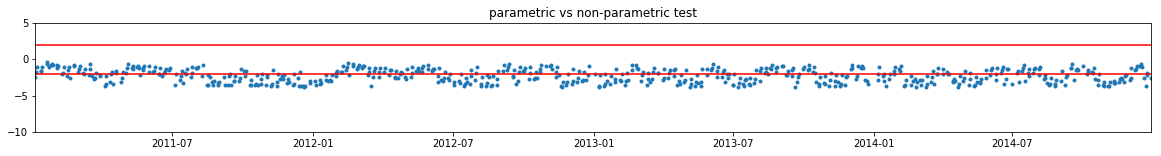

In [828]:
# T_k_deep = compute_test1_stats(Z_K_deep_arr, Pi_deep, Gamma1_deep, Gamma2_deep, H, Sigma, N_T)
# plot_tests(dates[date_col].values, T_k_deep, 'Deep OTM puts')
# T_k_mid = compute_test1_stats(Z_K_mid_arr, Pi_mid, Gamma1_mid, Gamma2_mid, H, Sigma, N_T)
# plot_tests(dates[date_col].values, T_k_mid, 'Mid OTM puts')

V_est_arr = pd.merge(sp500_m, dates[[date_col]], on=date_col, how = "inner")['V_est'].values
T_vf_arr = compute_test2_stats(V1_arr, V2_arr, V_est_arr, H, Sigma, Nt_arr, N_T)
plot_tests(dates[date_col].values, T_vf_arr, 'parametric vs non-parametric test', ylim = [-10, 5])

In [823]:
T_vf_arr

array([ 0.00509935,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [693]:
def get_params(option_dat, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j):
    g = option_dat.groupby([date_col])
    num_dates = option_dat[[date_col]].drop_duplicates().shape[0]
    V1_arr = np.zeros(num_dates)
    V2_arr = np.zeros(num_dates)
    mse_arr = np.zeros(num_dates)
    ind = 0
    for date, options in g:
        g2 = options.groupby([exp_date_col])
        Nt = options.shape[0]
        X = np.log(options[indx_col].tolist()[0])
        
        if (ind == 0):
            V1 = vbar1
            V2 = vbar2
        else:
            V1 = V1_arr[ind-1]
            V2 = V2_arr[ind-1]
            
        V_est = sp500_m[sp500_m[date_col] == date]['V_est'].values[0]
        sum_sq = 0
        f = lambda V : MSE(g2, X, V[0], V[1], r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                          eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j, Nt, V_est)['avg_err']
        res = minimize(f, [V1, V2], method='L-BFGS-B', bounds= [(1e-4, 1), (1e-4, 1)], tol=1e-4)

        mse_arr[ind] = res.fun
        V1_arr[ind] = res.x[0]
        V2_arr[ind] = res.x[1]
        print('Iteration ', ind, ' of ', num_dates, ', Nt = ', Nt)
        ind += 1
        
    return {'MSE' : mse_arr, 'V1_arr': V1_arr, 'V2_arr': V2_arr}

In [694]:
r = 0.005
div_rate = 0.03
kappa1 = 2
vbar1 = 0.0173
sigma1 = 0.2678
rho1 = -1

kappa2 = 11.5
vbar2 = 0.001
sigma2 = 0.3708
rho2 = -0.72

eta0 = 0.0033
eta1 = 20.27
eta2 = 5.074
mu_x = -0.1241
sigma_x = 0.1141
mu_y = 0.0850
rho_j = -0.3260

estimation_dates = long_dated[[date_col]].drop_duplicates()
estimation_dates = estimation_dates[estimation_dates[date_col].apply(is_wed)].reset_index()

est_dat2 = pd.merge(long_dated, estimation_dates, on=date_col, how="inner")
est_dat_after = est_dat2[est_dat2[date_col] > '2015-01-01'].reset_index()
err_long_dated2 = get_params(est_dat_after, r, div_rate, kappa1, vbar1, sigma1, rho1, kappa2, vbar2, sigma2, rho2, \
                 eta0, eta1, eta2, mu_x, sigma_x, mu_y, rho_j)
mse_arr = err_long_dated2['MSE'][~np.isnan(err_long_dated2['MSE'])]
print('The RMSE is', np.sqrt(np.sum(mse_arr) / mse_arr.shape[0]))

C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide


Iteration  0  of  54 , Nt =  818
Iteration  1  of  54 , Nt =  814
Iteration  2  of  54 , Nt =  792
Iteration  3  of  54 , Nt =  816
Iteration  4  of  54 , Nt =  762


C:\Users\Y\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in true_divide


Iteration  5  of  54 , Nt =  639
Iteration  6  of  54 , Nt =  755
Iteration  7  of  54 , Nt =  753
Iteration  8  of  54 , Nt =  730


KeyboardInterrupt: 

In [691]:
est_dat_after[[date_col]].drop_duplicates()

,date
0,2015-01-07
818,2015-01-14
1632,2015-01-21
2424,2015-01-28
3240,2015-02-04
4002,2015-02-11
4641,2015-02-18
5396,2015-02-25
6149,2015-03-04
6879,2015-03-11


In [487]:
from collections import OrderedDict
def f(z, a, b, c, d, e):
        return z + a + b + c + d + e
    
def big_f(z, a, b, c, d, e):
    arg_dict = OrderedDict([('a', a), ('b', b), ('d', d), ('e', e)])
    for arg in arg_dict:
        temp = arg_dict[arg]
        arg_dict[arg] = a
        print(f(z, c=c, **arg_dict))
        arg_dict[arg] = temp
    
big_f(6, 1, 2, 3, 4, 5)

21
20
18
17


In [692]:
valid_dates

,date
0,2011-01-03
1,2011-01-04
2,2011-01-05
5,2011-01-10
6,2011-01-11
7,2011-01-12
10,2011-01-18
11,2011-01-19
13,2011-01-21
14,2011-01-24


(25001, 13)